# LDA 2D Trialwise only (no continuous) 

In [3]:
%matplotlib inline

import sys, pathlib
sys.path.insert(0, str(pathlib.Path().absolute().parent))

from helper_scripts.helperFunctions import *
from helper_scripts.constants import *
from helper_scripts.dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
from helper_scripts.featureBuilder import featureBuilder


In [4]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


## Build dataframes and variables needed

In [6]:
# Load datas and concat into one dataframe 

# Load dataset 1
foldername='P001'
filename='part_P001_block_S004'
df1 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

# Load dataset 2
foldername='P001'
filename='part_P001_block_S005'
df2 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

df = pd.concat([df1, df2], ignore_index=True)

In [7]:
# Select the trials needed to classify
focused_state = df["trial_time"] == 0.7
unfocused_state = df["trial_time"] > 0.9
med_state = ((df["trial_time"] > 0.7) & (df["trial_time"] <= 0.9))

focused_df = df[focused_state]
unfocused_df = df[unfocused_state]
med_df = df[med_state]

num_to_keep = min(len(focused_df), len(unfocused_df), len(med_df))

focused_df = focused_df.drop(focused_df.sample(len(focused_df) - num_to_keep).index)
unfocused_df = unfocused_df.drop(unfocused_df.sample(len(unfocused_df) - num_to_keep).index)
med_df = med_df.drop(med_df.sample(len(med_df) - num_to_keep).index)

print("focused len:", len(focused_df), "unfocused len:", len(unfocused_df), "med len:", len(med_df))


focused len: 420 unfocused len: 420 med len: 420


In [8]:
# Create the dataframes
fb = featureBuilder()
dictionary = {}

for row_index,row in unfocused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=0, dictionary=dictionary)
for row_index,row in med_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=1, dictionary=dictionary)
for row_index,row in focused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=2, dictionary=dictionary)

feature_df = pd.DataFrame(dictionary)
len(feature_df)

1260

In [ ]:
for col in feature_df.columns: 
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="med") 
    
    
    
    plt.title(col)
    plt.legend()
    plt.show()

In [11]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=2)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    
    z_labels = lda.predict(X_test) #gives you the predicted label for each sample
    z_prob = lda.predict_proba(X_test) #the probability of each sample to belong to each class
    #Predict the response for test dataset
    y_pred = z_labels
    X_test = lda.transform(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA accuracy:", np.mean(np.array(accuracies)))


Accuracy 0.4166666666666667
Accuracy 0.4603174603174603
Accuracy 0.44047619047619047
Accuracy 0.38095238095238093
Accuracy 0.44841269841269843
Accuracy 0.4246031746031746
Accuracy 0.4444444444444444
Accuracy 0.36507936507936506
Accuracy 0.4365079365079365
Accuracy 0.36904761904761907
Avg LDA accuracy: 0.41865079365079366


In [12]:
# Top most effective 
num_effective = 10

zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
print("Most significant LDA Coefficients: ")
for elem in sorted_zip_list[:num_effective]:
    print(elem)
print()
for elem in sorted_zip_list[-num_effective:]:
    print(elem)

Most significant LDA Coefficients: 
(-10.299267467803393, 'left mean_first_difference')
(-9.716841325264893, 'left_minus_right mean_first_difference')
(-9.076022195821633, 'average norm_mean_second_difference')
(-8.05149445145398, 'average mean_first_difference')
(-7.105831706560019, 'right std_voltage')
(-4.688385043767125, 'left std_voltage')
(-4.354671959725581, 'left norm_mean_first_difference')
(-3.335577315696961, 'right mean_first_difference')
(-3.1251523931682414, 'left_minus_right norm_mean_second_difference')
(-2.4249542009404212, 'beta left')

(2.627158426260037, 'right norm_mean_second_difference')
(3.047571925137131, 'right mean_second_difference')
(4.043232614733833, 'left_minus_right norm_mean_first_difference')
(4.044504837248543, 'beta average')
(4.93930184550297, 'left_minus_right std_voltage')
(8.028080844061826, 'average mean_second_difference')
(10.599946502983991, 'left mean_second_difference')
(10.77736302015135, 'average norm_mean_first_difference')
(10.88182770

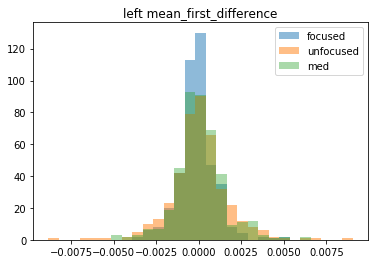

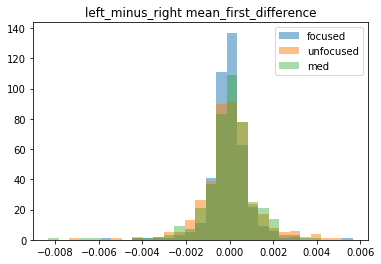

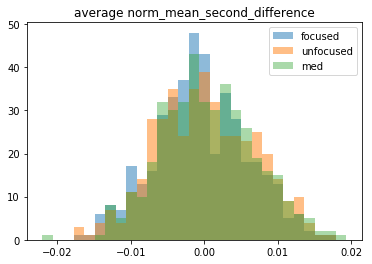

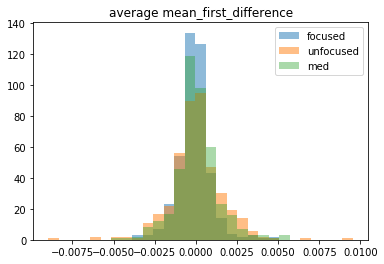

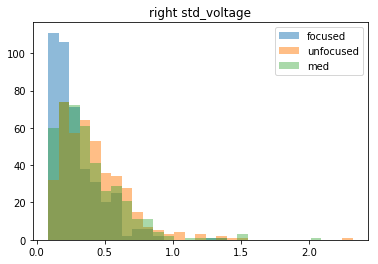

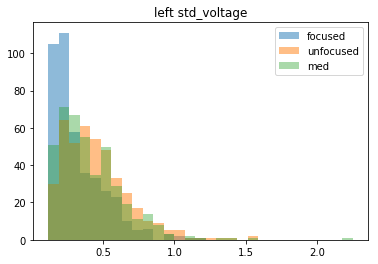

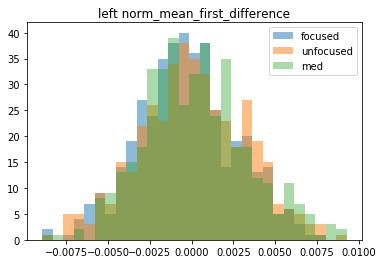

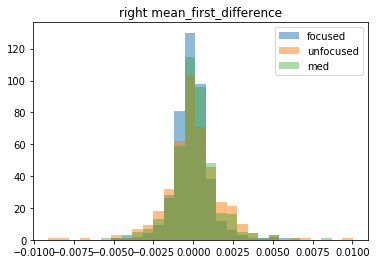

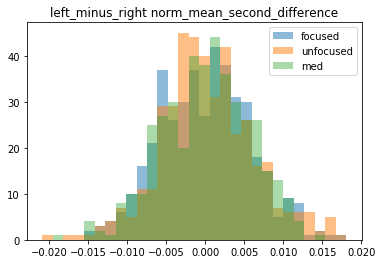

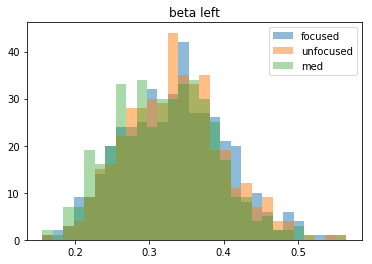

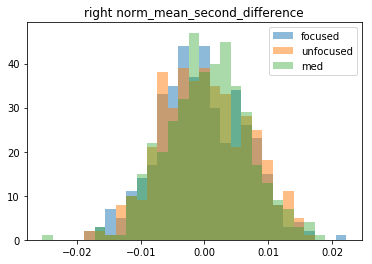

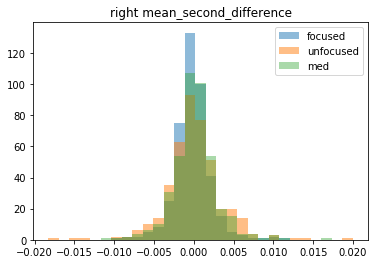

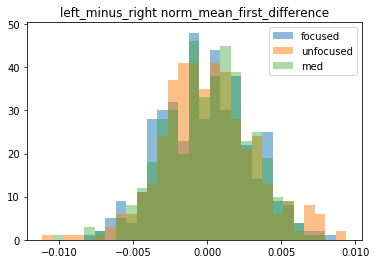

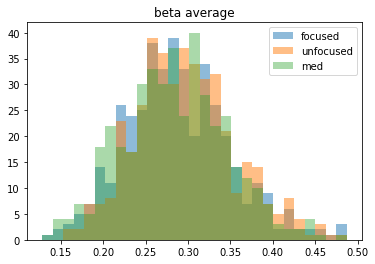

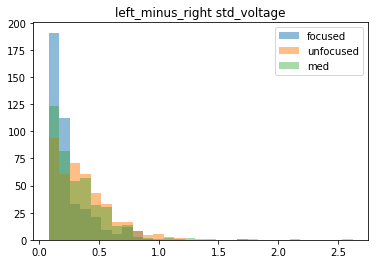

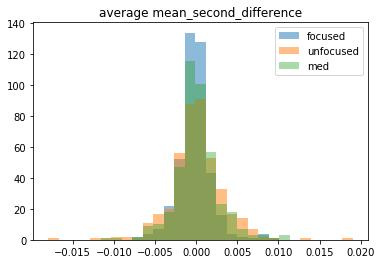

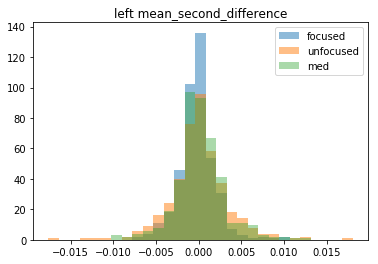

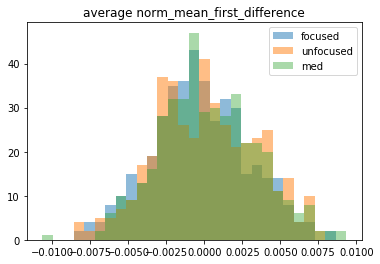

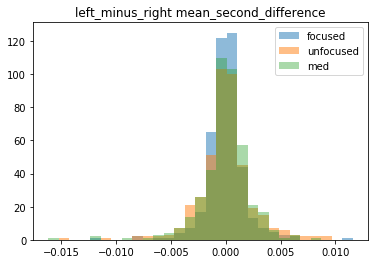

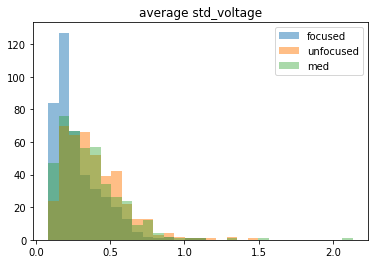

In [14]:
# Top most effective 
for elem in sorted_zip_list[:num_effective]:
    col=elem[1]
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.4, label="med")

   
    plt.title(col)
    plt.legend()
    plt.show()
print("==================================================")
for elem in sorted_zip_list[-num_effective:]:
    col=elem[1]
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.4, label="med")
    
   
    plt.title(col)
    plt.legend()
    plt.show()
    

LDA explained variance: [0.80140546 0.19859454]


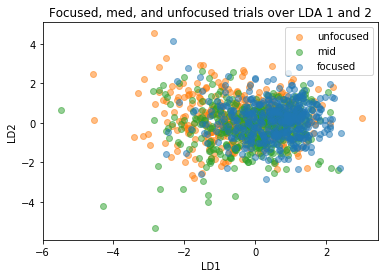

In [15]:
# Visualize LDA model 
# Needed for visualizing LDA components
class_names={2:"focused", 1:"mid", 0:"unfocused"}
colors={2:"C0", 1:"C2", 0:"C1"}

print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(np.concatenate([X_train, X_test]), columns=['LDA 1', 'LDA 2'])
lda_feature_df['focused']=np.concatenate([y_train.values, y_test.values])

# Plot groups wrt LDA 1 dimension
plt.xlabel('LD1')
plt.ylabel('LD2')

for class_name, df in lda_feature_df.groupby('focused'): 
    plt.scatter(
        df['LDA 1'].values,
        df['LDA 2'].values,
        c=colors[class_name],
        cmap='rainbow',
        alpha=0.5,
        label=class_names[class_name]
    )
plt.legend(loc='upper right')
plt.title("Focused, med, and unfocused trials over LDA 1 and 2")
plt.show()

## LDA manual
https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2

In [9]:
class_feature_means = pd.DataFrame(columns=[False,True])
for class_name, rows in feature_df.groupby('focused'):
    class_feature_means[class_name] = rows.mean()
    
class_feature_means = class_feature_means.drop(['focused'])

In [10]:
num_features = len(class_feature_means)
within_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(num_features, 1), class_feature_means[c].values.reshape(num_features, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s


In [11]:
feature_means = feature_df.mean().drop(['focused'])
between_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    n = len(rows)
    mc, m = class_feature_means[c].values.reshape(num_features, 1), feature_means.values.reshape(num_features, 1)
    between_class_scatter_matrix += n*(mc - m).dot((mc - m).T)

In [12]:
within_class_scatter_matrix.shape

(48, 48)

In [13]:
between_class_scatter_matrix.shape

(48, 48)

In [14]:
inv_within_class_scatter_matrix = np.linalg.pinv(within_class_scatter_matrix)

In [15]:
eigen_values, eigen_vectors = np.linalg.eig(inv_within_class_scatter_matrix.dot(between_class_scatter_matrix))


In [16]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

0.07439846588569235
0.04452282272393282
2.0868280427213818e-14
1.5123316424826227e-15
1.5123316424826227e-15
5.754735996385016e-16
3.439518326318062e-16
3.439518326318062e-16
3.385523825697202e-16
3.385523825697202e-16
2.236079651981054e-16
2.236079651981054e-16
1.33739450609809e-16
9.002336826778142e-17
7.935343273276738e-17
7.935343273276738e-17
6.85247219982934e-17
6.85247219982934e-17
3.205082604874352e-17
3.205082604874352e-17
2.8886081893529797e-17
2.8886081893529797e-17
2.6983657120515852e-17
2.2855072162304146e-17
2.2855072162304146e-17
2.2138539113267897e-17
1.6817496487767113e-17
1.6817496487767113e-17
1.1009146822585187e-17
7.536064545249375e-18
7.536064545249375e-18
7.48710141115237e-18
2.246404439402795e-18
2.246404439402795e-18
1.8641970983377276e-18
7.425390831785608e-19
7.623503733058104e-20
8.89978199465219e-21
3.1252883078545843e-33
3.1252883078545843e-33
1.3245076459038125e-33
1.3245076459038125e-33
7.161231434006543e-34
7.161231434006543e-34
7.15079112222706e-34
2.8

In [17]:
w_matrix = np.hstack((pairs[0][1].reshape(num_features,1), pairs[1][1].reshape(num_features,1))).real


In [18]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6256109966141358
Eigenvector 1: 0.37438900338603254
Eigenvector 2: 1.754797704532131e-13
Eigenvector 3: 1.2717080853767953e-14
Eigenvector 4: 1.2717080853767953e-14
Eigenvector 5: 4.8391133863985155e-15
Eigenvector 6: 2.8922645949534854e-15
Eigenvector 7: 2.8922645949534854e-15
Eigenvector 8: 2.846861033276557e-15
Eigenvector 9: 2.846861033276557e-15
Eigenvector 10: 1.880302238669526e-15
Eigenvector 11: 1.880302238669526e-15
Eigenvector 12: 1.12460478837266e-15
Eigenvector 13: 7.569996030173384e-16
Eigenvector 14: 6.672769330079231e-16
Eigenvector 15: 6.672769330079231e-16
Eigenvector 16: 5.762191345171712e-16
Eigenvector 17: 5.762191345171712e-16
Eigenvector 18: 2.6951293938598314e-16
Eigenvector 19: 2.6951293938598314e-16
Eigenvector 20: 2.429008483784349e-16
Eigenvector 21: 2.429008483784349e-16
Eigenvector 22: 2.269035042926402e-16
Eigenvector 23: 1.9218654985595376e-16
Eigenvector 24: 1.9218654985595376e-16
Eigenvector 25: 1.8616127837248972e-16

In [19]:
X_lda = np.array(feature_df.drop(columns=['focused']).dot(w_matrix))
X_lda

array([[-0.02958873,  0.11114413],
       [-0.03088476,  0.11393677],
       [-0.0199063 ,  0.12228797],
       ...,
       [-0.02839349,  0.11589241],
       [-0.02494543,  0.1146035 ],
       [-0.03061596,  0.1065048 ]])

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(feature_df['focused'])

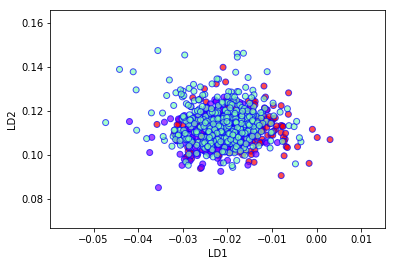

In [21]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)